<a id="index"></a>
# A modular processing pipeline for spiking data from axona raw data

The notebook largely follows the spiketutorial notebook from the Sep. 2020 developer workshop: https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb

In this notebook we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison for axona raw, axona unit and intan data. We will be using `spikeinterface` from the SpikeInterface github organization. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`.

We will show how to
1. [Install dependencies](#install_dependencies)
2. [load data with spikeextractors](#load_data)
3. [Preprocess the signals](#preprocess)
4. [Cache data](#cache)
5. [Run popular spike sorting algorithms with different parameters](#spike_sorting)
6. [Postprocessing](#postprocessing)
7. [Curate the spike sorting output](#spike_curation) using 1) quality metrics (automatic), 2) [Phy](https://github.com/cortex-lab/phy) (manual), and 3) consensus-based curation
8. [Export results to NWB](#export_nwb)
9. [Export results to TINT](#export_tint)


<a id='install_dependencies'></a>
# Install dependencies
[back to index](#index)

TODO streamline installation with requirements.txt, ultimately we will only use spikeinterface

We recommend creating a new `spiketutorial` conda environment using:

`conda env create -f environment.yml`

In addition, for the conda environment, you need to install [Phy](https://github.com/cortex-lab/phy) for the manual curation step.

`pip install phy --pre --upgrade`


Alternatively, you can install the requirements you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

(in this case Phy should be automatically installed)

Note that some spike sorters require matlab, which needs to be installed separately. For an overview of possible spike sorters and their dependencies see https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html.

In [10]:
!which python

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python


In [11]:
!ls -l

total 1456
-rwxrwxrwx 1 steburg steburg   54974 Apr  2 14:12 SpikeInterface_Tutorial.ipynb
-rwxrwxrwx 1 steburg steburg     451 Apr  2 11:01 channel_groups.prb
drwxrwxrwx 1 steburg steburg    4096 Apr  1 21:38 ironclust
-rwxrwxrwx 1 steburg steburg 1432737 Apr  2 14:34 milestone2_modular_pipeline_colab.ipynb
drwxrwxrwx 1 steburg steburg    4096 Apr  1 19:29 python-neo
drwxrwxrwx 1 steburg steburg    4096 Apr  1 19:30 spikeextractors
drwxrwxrwx 1 steburg steburg    4096 Apr  1 19:41 venv


In [12]:
# Ultimately this is the only command needed, but for now we need
# to install from github to obtain work in progress.

#!pip install spikeinterface

Once axonarecordingextractors are integrated into spikeextractors, 
installing spikeinterface should be sufficient. For now we also need to
clone spikeextractors and python-neo with the necessary components
(e.g. branch axonarawio for python-neo).

In [ ]:
!git clone https://github.com/catalystneuro/python-neo.git

Cloning into 'python-neo'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (143/143), done.:  72% (103/143)


In [ ]:
!ls -l

In [6]:
%cd ./python-neo
!python3 setup.py develop
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
running develop
running egg_info
writing neo.egg-info/PKG-INFO
writing dependency_links to neo.egg-info/dependency_links.txt
writing requirements to neo.egg-info/requires.txt
writing top-level names to neo.egg-info/top_level.txt
reading manifest file 'neo.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'drafts'
no previously-included directories found matching 'doc/build'
writing manifest file 'neo.egg-info/SOURCES.txt'
running build_ext
Creating /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/neo.egg-link (link to .)
Adding neo 0.9.0 to easy-install.pth file

Installed /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
Processing dependencies for neo==0.9.0
Searching for quantities>=0.12.1
Reading https://pypi.org/simple/quantities/
Best match: quantities 0.12.4
Processing quantities-0.12.4.tar.gz
Writing /tmp/easy_install-

In [68]:
!git clone https://github.com/catalystneuro/spikeextractors.git

fatal: destination path 'spikeextractors' already exists and is not an empty directory.


In [7]:
%cd ./spikeextractors
!python3 setup.py develop
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
running develop
running egg_info
writing spikeextractors.egg-info/PKG-INFO
writing dependency_links to spikeextractors.egg-info/dependency_links.txt
writing requirements to spikeextractors.egg-info/requires.txt
writing top-level names to spikeextractors.egg-info/top_level.txt
reading manifest file 'spikeextractors.egg-info/SOURCES.txt'
writing manifest file 'spikeextractors.egg-info/SOURCES.txt'
running build_ext
Creating /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spikeextractors.egg-link (link to .)
Adding spikeextractors 0.9.5 to easy-install.pth file

Installed /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
Processing dependencies for spikeextractors==0.9.5
Searching for tqdm
Reading https://pypi.org/simple/tqdm/
Best match: tqdm 4.59.0
Processing tqdm-4.59.0-py2.py3-none-any.whl
Installing tqdm-4.59.0-py2.py3-none-any.whl to /mnt/d/spikeinterface/hussaini-to-nwb/ti

Switch to correct branches

In [8]:
%cd python-neo
!git checkout axonarawio
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/python-neo
Already on 'axonarawio'
Your branch is up to date with 'origin/axonarawio'.
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv


In [9]:
%cd spikeextractors
!git checkout axonaextractor
%cd ..

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors
Already on 'axonaextractor'
Your branch is up to date with 'origin/axonaextractor'.
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv


Install other spikeinterface modules using pip (this may take a few minutes). 

In [10]:
!pip install spiketoolkit spikesorters spikecomparison spikewidgets

     |████████████████████████████████| 67 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 1.3 MB/s eta 0:00:01
  Using cached spikecomparison-0.3.2-py3-none-any.whl (28 kB)
  Using cached networkx-2.5-py3-none-any.whl (1.6 MB)
  Using cached pandas-1.2.3-cp38-cp38-manylinux1_x86_64.whl (9.7 MB)
  Using cached scikit_learn-0.24.1-cp38-cp38-manylinux2010_x86_64.whl (24.9 MB)
     |████████████████████████████████| 27.2 MB 1.5 MB/s eta 0:00:01     |███████████████████████████████ | 26.4 MB 9.2 MB/s eta 0:00:01
  Using cached spikefeatures-0.1.2.tar.gz (4.5 kB)
  Using cached spikemetrics-0.2.4.tar.gz (18 kB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached MEAutility-1.4.8.tar.gz (33 kB)
     |████████████████████████████████| 10.3 MB 4.2 MB/s eta 0:00:01    |██████▍                         | 2.1 MB 5.8 MB/s eta 0:00:02     |██████████████████████████████▎ | 9.7 MB 4.2 MB/s eta 0:00:01
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB

  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-zvap1k0e/MEAutility/setup.py'"'"'; __file__='"'"'/tmp/pip-install-zvap1k0e/MEAutility/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-7v4e8p3m
       cwd: /tmp/pip-install-zvap1k0e/MEAutility/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for MEAutility
  Running setup.py clean for MEAutility
Failed to build spiketoolkit spikesorters spikewidgets spikefeatures sp

Finally, we should downgrade h5py to version 2.10.0 to be as compatible as possible with spikesorters

In [3]:
!pip install h5py==2.10.0

  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)


Note: __You need to restart the kernel before you can import the newly installed packages__.

Import packages

In [13]:
# General data handling and visualization
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size':20})

# SpikeInterface
import spikeextractors as se
import spikewidgets as sw
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc

print(sys.version, sys.platform, sys.executable)

3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0] linux /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3


We can see which recordingextractors exist, and which ones are installed and available to us.

In [21]:
se.recording_extractor_full_list

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.mearecextractors.mearecextractors.MEArecRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.exdirextractors.exdirextractors.ExdirRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysNPIXRecordingExtractor,
 spikeextractors.extractors.intanrecordingextractor.intanrecordingextractor.IntanRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spyking

In [22]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxwellextractors.maxwellextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.maxwellextractors.maxwellextractors.MaxTwoRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.m

<a id='load_data'></a>
# 2. Load data
[back to index](#index)

Set path and base filename and create an AxonaRecordingExtractor instance.

In [17]:
dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = 'axona_raw_5s'
filename = os.path.join(dir_name, base_filename)
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/axona_raw_5s


In [25]:
recording = se.AxonaRecordingExtractor(filename=filename)

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). 

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [26]:
print('Type of recorindextractor:', type(recording))
print('Channel ids: {}'.format(recording.get_channel_ids()))
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. samples = {}'.format(recording.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(axo_cont.get_traces(
    start_frame=0, end_frame=48000, channel_ids=2))))
print('Location of third electrode = {}'.format(recording.get_channel_property(channel_id=2, property_name='location')))

Type of recorindextractor: <class 'spikeextractors.extractors.neoextractors.axonaextractor.AxonaRecordingExtractor'>
Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Num. channels = 16
Sampling frequency = 48000.0 Hz
Num. samples = 720000
Stdev. on third channel = 7191.7255859375
Location of third electrode = [nan nan]


Visualize channels in time domain (from 2.0 to 2.1 seconds).

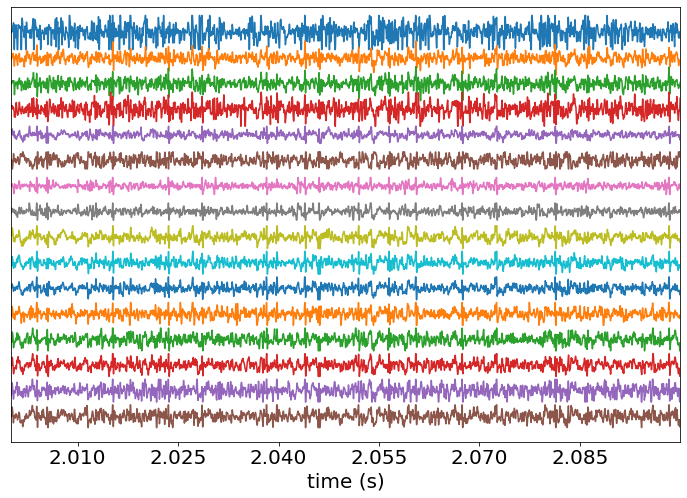

In [20]:
w_ts = sw.plot_timeseries(recording, trange=[2, 2.1])

Plot a subset of 8 channels in the frequency domain (5s time window).

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

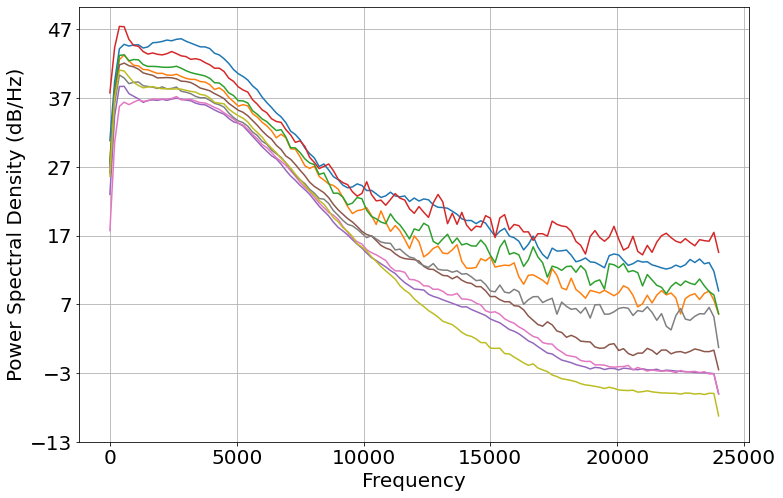

In [6]:
w_sp = sw.plot_spectrum(recording, trange=[0, 5], channels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

It often makes sense to group electrodes together, for instance if they belong to the same tetrode. We can do so by assigning the `groups` property for each channel. This can be done with the `set_channel_groups` method. Correspondingly, we can view this property using the `get_channel_groups` method. Initially all channels are assigned to group zero.  

In [7]:
print(f'Channel groups at initialization:\n{recording.get_channel_groups()}')

Channel groups at initialization:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
recording.set_channel_groups([i//4 for i in range(len(recording.get_channel_ids()))])

print(f'Updated channel groups with a 4 channel per tetrode scheme:\n{recording.get_channel_groups()}')

Updated channel groups with a 4 channel per tetrode scheme:
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


Some spike sorters (e.g. ironclust) require channel locations. So we will create a fake geometry keeping electrodes on single tetrodes close together. A common way to do this is with a .prb file containing a json dictionary like the one below. If the actual geometry is known, you can of course use that instead. 

In [9]:
# We simply paste this code into a .prb file
prb_file_content = '''
channel_groups = {
    0: {
        'channels': [0, 1, 2, 3],
        'geometry': [[0, 0], [1, 0], [2, 0], [3, 0]],
    },
    1: {
        'channels': [4, 5, 6, 7],
        'geometry': [[6, 0], [7, 0], [8, 0], [9, 0]],
    },
    2: {
        'channels': [8, 9, 10, 11],
        'geometry': [[12, 0], [13, 0], [14, 0], [15, 0]],
    },
    3: {
        'channels': [12, 13, 14, 15],
        'geometry': [[18, 0], [19, 0], [20, 0], [21, 0]],
    }
}
'''
f = open("channel_groups.prb", "w")
f.write(prb_file_content)
f.close()

We now have the additional channel property location.

In [10]:
recording_prb = recording.load_probe_file(os.path.join(dir_name, 'channel_groups.prb'))
print('Channel ids:', recording_prb.get_channel_ids())
print('Loaded properties', recording_prb.get_shared_channel_property_names())

# 'group' and 'location' can be returned as lists:
print('Channel groups:', recording_prb.get_channel_groups())
print('Channel locations:\n', recording_prb.get_channel_locations())

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Loaded properties ['gain', 'group', 'location', 'name', 'offset']
Channel groups: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Channel locations:
 [[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]
 [ 3.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [12.  0.]
 [13.  0.]
 [14.  0.]
 [15.  0.]
 [18.  0.]
 [19.  0.]
 [20.  0.]
 [21.  0.]]


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

We can also visualize the electrode locations with spikewidgets:

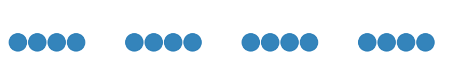

In [11]:
fh = plt.figure(figsize=(8,1))
w_elec = sw.plot_electrode_geometry(recording_prb, figure=fh)

Note that not all channel properties are shared ... TODO say more about shared vs not shared channel properties. 

In [12]:
print('Shared channel property names')
print(recording.get_shared_channel_property_names())

Shared channel property names
['gain', 'group', 'name', 'offset']


<a id='preprocess'></a>
# 3. Preprocessing
[back to index](#index)

TODO ... Give general overview of preprocessing options and why it is useful to do this in spikeinterface vs when using a specific spikesorter.

### Bandpass filter

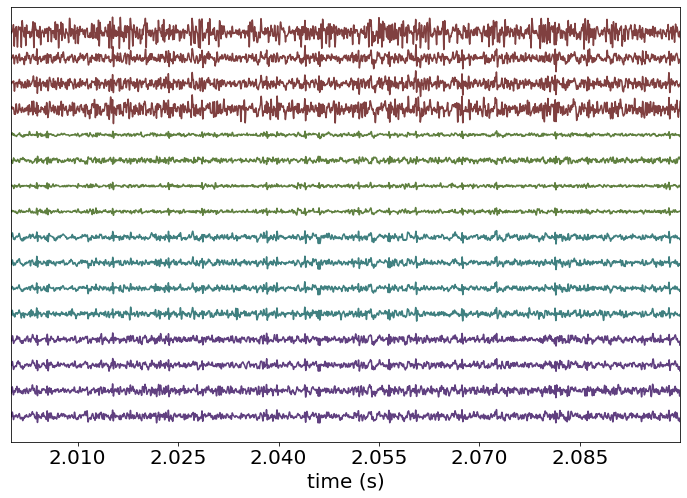

In [13]:
r_filt = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(r_filt, trange=[2, 2.1], color_groups=True)

Channels from the first tetrode seem somewhat noisier than the rest. To illustrate how to exclude channels (or whole tetrodes) we will remove it: TODO 

### Common median reference (CMR)

It is common to use a common median reference to remove activity common to all channels. Such activity cannot be evoked by a single unit, since only channels from a single tetrode should be within reach to pick up some of its activity. 

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

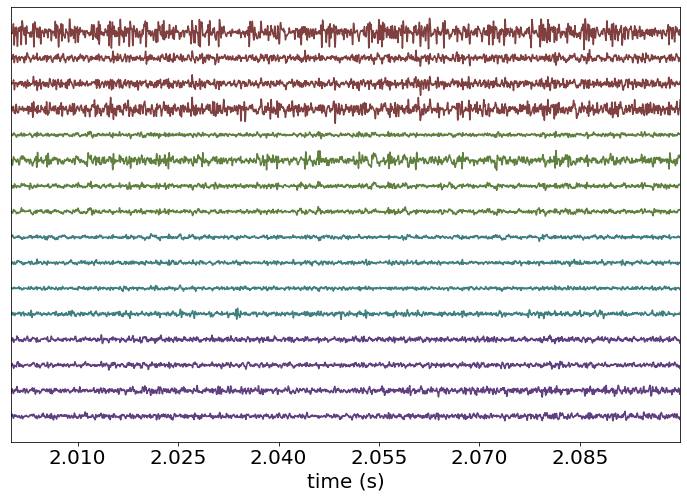

In [14]:
r_cmr = st.preprocessing.common_reference(r_filt, reference='median')
w = sw.plot_timeseries(r_cmr, trange=[2.0, 2.1], color_groups=True)

This doesn't change much, because as you can see in the data before rereferencing, the spikes are seen in all channels, so rereferencing to median is going to attentuate them all...

Hmm, for the second channel on the second tetrode the "common spikes" are actually inverted, making them even stronger after median referencing. What is going on?

In [15]:
# We can also select subsets of data. We only have 5s of data, so let's simply choose all the data

fs = r_cmr.get_sampling_frequency()
r_sub = se.SubRecordingExtractor(r_cmr, start_frame=0*fs, end_frame=5*fs)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextract

<a id='cache'></a>
# 4. Cache data
[back to index](#index)

In [16]:
# Create a binary file to cache data

perma_cache_filename = os.path.join(dir_name, 'cached_data_preproc.dat') 
r_cache = se.CacheRecordingExtractor(r_sub, save_path = perma_cache_filename)

In [17]:
print(r_cache.filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/cached_data_preproc.dat


In [18]:
# Save corresponding extractor state to be able to read binary data after closing session

r_cache.dump_to_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In [3]:
# Load cached state to continue session

r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In [4]:
print('duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

duration of recording in seconds: 5.0


<a id='spike_sorting'></a>
# 5. Spike sorting
[back to index](#index)

First, we need to install spike sorters. There is a complete overview of spike sorters supported by spikeinterface here: https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html, including installation instructions or pointers to them. Note that not all spikesorters work on every setup. Some require matlab. Some require CUDA. In this notebook we will focus on ironclust, kilosort, spyking circus and mountainsort. 

Focus on the following spike sorters:

The kilosorts, ironclust, spyking circus, mountainsort.

In [27]:
# Show installed spike sorting algorithms

ss.installed_sorters()

[]

In [ ]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [ ]:
ss.get_params_description('klusta')

{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'num_starting_clusters': 'Number of initial clusters',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [ ]:
ss.run_sorter?

In [ ]:
ss.run_klusta?

### Klusta

In [ ]:
# run spike sorting on 10s of recording

sorting_KL_all = ss.run_klusta(
    r_cache, 
    output_folder=os.path.join(dir_name, 'klusta_10s'), 
    adjacency_radius=50, 
    verbose=True
)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.


/mnt/d/spikeinterface/spikeextractors/spikeextractors/baseextractor.py:607: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(v, (np.int, np.int32, np.int64)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/baseextractor.py:609: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guida

RUNNING SHELL SCRIPT: /mnt/d/spikeinterface/hussaini-to-nwb/../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/klusta_10s/run_klusta.sh
12:28:18 [I] creator:446          Using kwik file `/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/klusta_10s/recording.kwik`.

12:28:19 [I] launch:206           Starting spike detection.

12:28:19 [I] launch:53            SpikeDetekt parameters:

12:28:19 [I] launch:55            chunk_overlap_seconds = 0.015

12:28:19 [I] launch:55            chunk_size_seconds = 3

12:28:19 [I] launch:55            connected_component_join_size = 1

12:28:19 [I] launch:55            detect_spikes = negative

12:28:19 [I] launch:55            dtype = <f4

12:28:19 [I] launch:55            excerpt_size_seconds = 1

12:28:19 [I] launch:55            experiment_name = recording.kwik

12:28:19 [I] launch:55            extract_s_after = 32

12:28:19 [I] launch:55            extract_s_before = 16

12:28:19 [I] launch:55      

KeyboardInterrupt: 

In [ ]:
# run spike sorting by group (=tetrode)

sorting_KL = ss.run_klusta(
    r_cache, 
    adjacency_radius=50, 
    output_folder=os.path.join(dir_name, 'klusta_10s_by_group'), 
    grouping_property='group', 
    parallel=True
)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

Klusta found 24 units


Hm, interesting, sorting for each tetrode separately yielded more units.

In [ ]:
print(f'Klusta unit ids: {sorting_KL.get_unit_ids()}')

Klusta unit ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [ ]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(1)}')

Spike train of a unit: [  5169   7133  14929  22194  28803  33676  44279  46563  47483  47784
  55374  63412  65222  65839  76089  89378  90866  91185  96914  98452
 100145 102884 105006 105309 108187 109146 110588 110773 114339 114822
 115394 118442 121372 121885 123669 129130 137151 146218 150390 151388
 171017 178791 179624 179957 181754 184281 210518 211998 214060 222591
 228370 228891 229124 235676 237420 240689 245397 246152 248226 248360
 250939 254000 257530 258888 259574 260233 260743 269428 271792 272722
 275346 282130 288947 293763 302343 304486 304594 307374 314822 317805
 318102 330733 336374 340884 346997 377779 378466 379218 379285 384872
 386035 388278 391009 392802 399570 545378 548813 550172 553325 555933
 558347 561993 564092 564324 565595 565642 575393 583844 596825 596871
 597849 597895 602676 602982 603700 604006 605645 606036 606669 607060
 618518 619542 621529 622553 651073 651422 653887 659937 661316 664430
 664449 665322 673883 675298 675573 677003 680999 6823

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

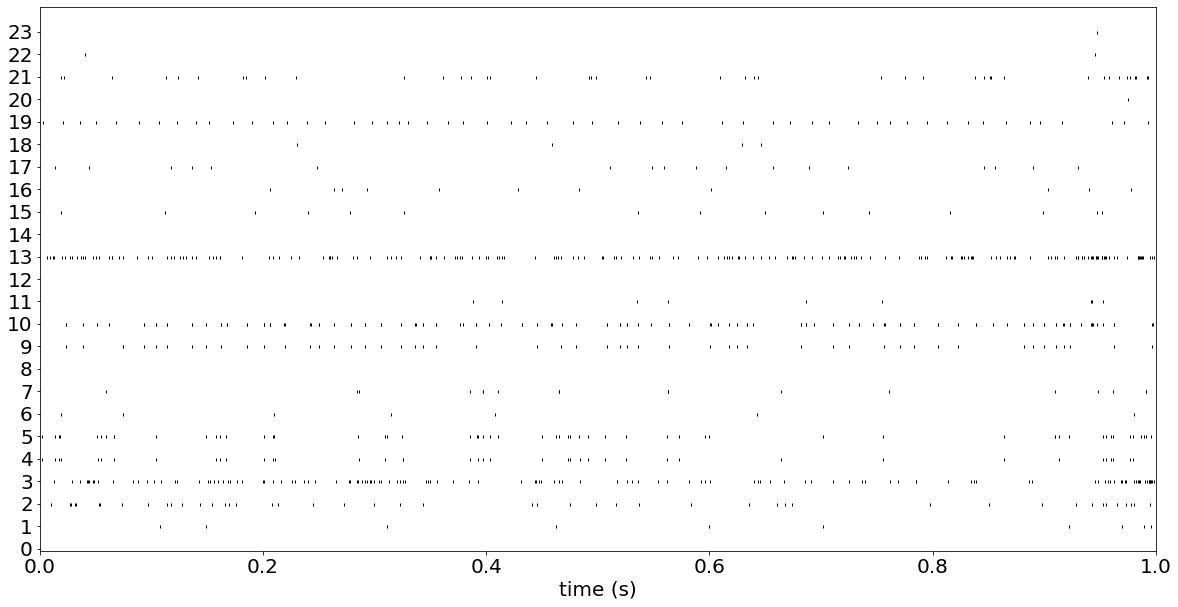

In [ ]:
w_rs = sw.plot_rasters(sorting_KL, trange=[0,1])

In [ ]:
# Reloading spike sorting output (note that if sorting by group or property they need to be loaded in separately)

sorting_KL_grp = {}
for i in range(0, 4):
    sorting_KL_grp[i] = se.KlustaSortingExtractor(os.path.join(dir_name, 'klusta_20s_by_group', str(i)))

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sorting_KL_grp

{0: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7f82680f3af0>,
 1: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7f8268a938b0>,
 2: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7f8268b32ca0>,
 3: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7f83b05a43d0>}

In [ ]:
print(f'Klusta unit ids group 0: {sorting_KL_grp[0].get_unit_ids()}')

Klusta unit ids group 0: [0, 2, 3, 4, 5, 6, 7, 8, 9]


### Ironclust

TODO add instructinos of how to add matlab to python search path. 

Clone Ironclust github repository to a path or your choice. Here we stay in the same directory. 

In [29]:
!git clone https://github.com/jamesjun/ironclust

Cloning into 'ironclust'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 4964 (delta 131), reused 119 (delta 62), pack-reused 4775
Receiving objects: 100% (4964/4964), 83.82 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (3556/3556), done.
Updating files: 100% (846/846), done.


In [24]:
ss.get_default_params('ironclust')

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 1,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [25]:
ss.get_params_description('ironclust')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

In [21]:
# Set ironclust path (ironclust uses Matlab)

ss.IronClustSorter.set_ironclust_path('./ironclust')
ss.IronClustSorter.ironclust_path

Setting IRONCLUST_PATH environment variable for subprocess calls to: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust


'/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust'

In [22]:
ss.installed_sorters()

['ironclust', 'mountainsort4']

In [26]:
# run spike sorting by group 
sorting_IC = ss.run_ironclust(
    r_cache, 
    os.path.join(dir_name, 'ironclust_group'), 
    grouping_property='group', 
    parallel=True, 
    verbose=True,
    filter=False,  # we already filtered
    detect_threshold=3,  # similar to other sorters
    common_ref_type=None  # we already applied median reference
)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

Writing to binary .dat file: 100%|##########| 1/1 [00:00<00:00,  9.60it/s]


ironclust run time 124.75s
IronClust found 4 units


### Mountainsort4

To install Mountainsort4, instead of cloning the github repo we simply install using pip. Remember to restart the kernel after installing it for the first time. It installs quite a large number of packages, so this might take a few minutes. 

In [33]:
!pip install ml_ms4alg

  Using cached ml_ms4alg-0.3.6-py3-none-any.whl (16 kB)
  Using cached isosplit5-0.1.3.tar.gz (17 kB)
  Using cached pybind11-2.6.2-py2.py3-none-any.whl (191 kB)
     |████████████████████████████████| 935 kB 3.0 MB/s eta 0:00:01
  Using cached h5py-3.2.1-cp38-cp38-manylinux1_x86_64.whl (4.5 MB)
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached mountainlab_pytools-0.7.5-py3-none-any.whl (28 kB)
  Using cached fsspec-0.8.7-py3-none-any.whl (103 kB)
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
  Using cached toolz-0.11.1-py3-none-any.whl (55 kB)
  Using cached partd-1.1.0-py3-none-any.whl (19 kB)
  Using cached jp_proxy_widget-1.0.10-py2.py3-none-any.whl (1.2 MB)
  Using cached vdom-0.6-py3-none-any.whl (13 kB)
  Using cached numpydoc-1.1.0-py3-none-any.whl (47 kB)
  Using cached locket-0.2.1-py2.py3-none-any.whl (4.1 kB)
  Using cached jupyter_ui_poll-0.1.2-py2.py3-none-any.whl (6.6 kB)
  Using cached Sphinx-3.5.3-py3-none-any.whl (2.8 MB)
  Using cached sphinxcontr

  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-3awm75ww/isosplit5/setup.py'"'"'; __file__='"'"'/tmp/pip-install-3awm75ww/isosplit5/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-arz0jqbb
       cwd: /tmp/pip-install-3awm75ww/isosplit5/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for isosplit5
  Running setup.py clean for isosplit5
  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeint

In [11]:
!pip install loky

  Using cached loky-2.9.0-py2.py3-none-any.whl (67 kB)


In [27]:
ss.installed_sorters()

['ironclust', 'mountainsort4']

In [28]:
ss.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': True,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [29]:
ss.get_params_description('mountainsort4')

{'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood (Use -1 to include all channels in every neighborhood)',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'filter': 'Enable or disable filter',
 'whiten': 'Enable or disable whitening',
 'curation': 'Enable or disable curation',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'clip_size': 'Number of samples per waveform',
 'detect_threshold': 'Threshold for spike detection',
 'detect_interval': 'Minimum number of timepoints between events detected on the same channel',
 'noise_overlap_threshold': 'Noise overlap threshold for automatic curation'}

In [30]:
# run spike sorting by group
sorting_MS4 = ss.run_mountainsort4(
    r_cache,
    os.path.join(dir_name, 'mountainsort4_group'),
    grouping_property='group',
    parallel=True,
    verbose=True,
    filter=False
)
print(f'Mountainsort4 found {len(sorting_MS4.get_unit_ids())} units')

KeyboardInterrupt: 

In [ ]:
print(f'Spike train of a unit: {sorting_MS4.get_unit_spike_train(1)}')

### 1. Kilosort
Kilosort, Kilosort2 and Kilosort2.5 all require CUDA, so let's install this first.

In [58]:
# TODO install CUDA

We can install Kilosort by simply cloning the git repository and pointing spikeinterface to the download path.

In [59]:
!git clone https://github.com/cortex-lab/KiloSort

Cloning into 'KiloSort'...
remote: Enumerating objects: 1207, done.
remote: Total 1207 (delta 0), reused 0 (delta 0), pack-reused 1207
Receiving objects: 100% (1207/1207), 2.30 MiB | 5.22 MiB/s, done.
Resolving deltas: 100% (763/763), done.


In [60]:
!ls -l

total 116308
-rw-r--r--  1 root root 103680000 Apr  1 19:26 axona_raw_5s.bin
-rw-r--r--  1 root root     26002 Apr  1 21:38 axona_raw_5s.set
-rw-r--r--  1 root root  15360000 Apr  1 22:07 cached_data_preproc.dat
-rw-r--r--  1 root root      3538 Apr  1 22:07 cached_data_preproc.pkl
-rw-r--r--  1 root root       451 Apr  1 21:53 channel_groups.prb
drwxr-xr-x 15 root root      4096 Apr  1 22:12 KiloSort
drwxr-xr-x  8 root root      4096 Apr  1 19:51 python-neo
drwxr-xr-x  1 root root      4096 Mar 25 13:38 sample_data
drwxr-xr-x  7 root root      4096 Apr  1 19:59 spikeextractors


In [61]:
ss.KilosortSorter.set_kilosort_path('./KiloSort')
ss.KilosortSorter.kilosort_path

Setting KILOSORT_PATH environment variable for subprocess calls to: /content/KiloSort


'/content/KiloSort'

We can inspect a given spike sorters parameters and see a description of their purpose using the following convenience methods.

In [62]:
ss.get_default_params('kilosort')

{'NT': None,
 'Nfilt': None,
 'car': True,
 'chunk_mb': 500,
 'detect_threshold': 6,
 'freq_max': 6000,
 'freq_min': 300,
 'n_jobs_bin': 1,
 'ntbuff': 64,
 'useGPU': True}

In [63]:
ss.get_params_description('kilosort')

{'NT': 'Batch size (if None it is automatically computed)',
 'Nfilt': 'Number of clusters to use (if None it is automatically computed)',
 'car': 'Enable or disable common reference',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'detect_threshold': 'Threshold for spike detection',
 'freq_max': 'Low-pass filter cutoff frequency',
 'freq_min': 'High-pass filter cutoff frequency',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)',
 'ntbuff': 'Samples of symmetrical buffer for whitening and spike detection',
 'useGPU': 'Enable or disable GPU usage'}

Now we call the spike sorter. 

In [70]:
!less kilosort_group/0/kilosort.log

/content/kilosort_group/0/run_kilosort.sh: line 3: matlab: command not found
>8

In [64]:
sorting_KS = ss.run_kilosort(
    r_cache,
    os.path.join(dir_name, 'kilosort_group'),
    grouping_property='group',
    parallel=True,
    verbose=True
)
print(f'Kilosort found {len(sorting_KS.get_unit_ids())} units')

Writing to binary .dat file: 100%|##########| 1/1 [00:00<00:00, 158.07it/s]


SpikeSortingError: ignored

### Kilosort2

In [ ]:
# Add repository path to spikesorters object

ss.Kilosort2Sorter.set_kilosort2_path('../specific_spikesorters/Kilosort2')
ss.Kilosort2Sorter.kilosort2_path

Setting KILOSORT2_PATH environment variable for subprocess calls to: /mnt/d/spikeinterface/hussaini-to-nwb/../specific_spikesorters/Kilosort2


'/mnt/d/spikeinterface/hussaini-to-nwb/../specific_spikesorters/Kilosort2'

### Kilosort2.5

In [ ]:
# Add repository path to spikesorters object
# WRONG ATTRIBUTE... what's the right one?!

ss.Kilosort2_5Sorter.set_kilosort2_path('../specific_spikesorters/kilosort25/kilosort')
ss.Kilosort2_5Sorter?

AttributeError: type object 'Kilosort2_5Sorter' has no attribute 'set_kilosort2_path'

### SpykingCircus

Installing spyking circus

In [44]:
from getpass import getpass

!echo {getpass()} | sudo -S apt install libmpich-dev

········
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmpich-dev is already the newest version (3.3.2-2build1).
0 upgraded, 0 newly installed, 0 to remove and 244 not upgraded.


In [45]:
!pip install mpi4py
!pip install spyking-circus --no-binary=mpi4py

  Using cached mpi4py-3.0.3.tar.gz (1.4 MB)
  ERROR: Command errored out with exit status 1:
   command: /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-4unaq9yk/mpi4py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-4unaq9yk/mpi4py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-ld8fkc0q
       cwd: /tmp/pip-install-4unaq9yk/mpi4py/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: setup.py --help [cmd1 cmd2 ...]
     or: setup.py --help-commands
     or: setup.py cmd --help
  
  error: invalid command 'bdist_wheel'
  ----------------------------------------
  ERROR: Failed building wheel for mpi4py
  Running setup.py clean for mpi4py
Failed to build mpi4py
    Running setup.py ins

In [5]:
ss.get_default_params('spykingcircus')

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [6]:
ss.get_params_description('spykingcircus')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood',
 'detect_threshold': 'Threshold for spike detection',
 'template_width_ms': 'Template width in ms. Recommended values: 3 for in vivo - 5 for in vitro',
 'filter': 'Enable or disable filter',
 'merge_spikes': 'Enable or disable automatic mergind',
 'auto_merge': 'Automatic merging threshold',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'whitening_max_elts': 'Max number of events per electrode for whitening',
 'clustering_max_elts': 'Max number of events per electrode for clustering'}

In [9]:
ss.run_spykingcircus?

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
sorting_SC = ss.run_spykingcircus(
    r_cache,
    os.path.join(dir_name, 'spykingcircus_group'),
    grouping_property='group',
    parallel=True,
    verbose=True
)
print(f'Spyking Circus found {len(sorting_SC.get_unit_ids())} units')

spykingcircus run time 10.05s


SpikeSortingError: Failed to load sorting output 0

<a id='postprocessing'></a>
# 6. Postprocessing
[back to index](#index)

The `postprocessing` submodule of `spiketoolkit` allows us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

In [ ]:
# Extract waveforms

waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_KL, verbose=True)

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


In [ ]:
# Only up to 300 waveforms are extracted by default

waveforms[1].shape

(300, 16, 288)

In [ ]:
# But in total the second unit has 464

len(sorting_KL.get_unit_spike_train(1))

3399

In [ ]:
sorting_KL.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

In [ ]:
print(sorting_KL.get_unit_spike_features(0, 'waveforms_idxs'))

[0 1 2 3 4]


In [ ]:
# Waveforms are stored for convenience in tmp folder

tmp_folder = sorting_KL.get_tmp_folder()
print(tmp_folder)
print([(p.name) for p in tmp_folder.iterdir()])

/tmp/tmpdju41aa6
['waveforms_0.raw', 'waveforms_1.raw', 'waveforms_10.raw', 'waveforms_11.raw', 'waveforms_12.raw', 'waveforms_13.raw', 'waveforms_14.raw', 'waveforms_15.raw', 'waveforms_16.raw', 'waveforms_17.raw', 'waveforms_18.raw', 'waveforms_19.raw', 'waveforms_2.raw', 'waveforms_20.raw', 'waveforms_21.raw', 'waveforms_22.raw', 'waveforms_23.raw', 'waveforms_24.raw', 'waveforms_3.raw', 'waveforms_4.raw', 'waveforms_5.raw', 'waveforms_6.raw', 'waveforms_7.raw', 'waveforms_8.raw', 'waveforms_9.raw']


In [ ]:
waveforms_group = st.postprocessing.get_unit_waveforms(
    r_cache, sorting_KL, max_spikes_per_unit=None, 
    grouping_property='group', recompute_info=True,
    verbose=True
)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:01<00:00,  1.68s/it]


In [ ]:
sorting_KL.get_shared_unit_property_names()

['group', 'quality', 'waveforms_channel_idxs']

In [ ]:
for wf in waveforms_group:
    print(wf.shape)

(5, 4, 288)
(3399, 4, 288)
(1128, 4, 288)
(1024, 4, 288)
(1404, 4, 288)
(216, 4, 288)
(1252, 4, 288)
(184, 4, 288)
(2, 4, 288)
(277, 4, 288)
(274, 4, 288)
(4992, 4, 288)
(90, 4, 288)
(826, 4, 288)
(2135, 4, 288)
(4, 4, 288)
(269, 4, 288)
(383, 4, 288)
(285, 4, 288)
(43, 4, 288)
(863, 4, 288)
(11, 4, 288)
(1321, 4, 288)
(107, 4, 288)
(107, 4, 288)


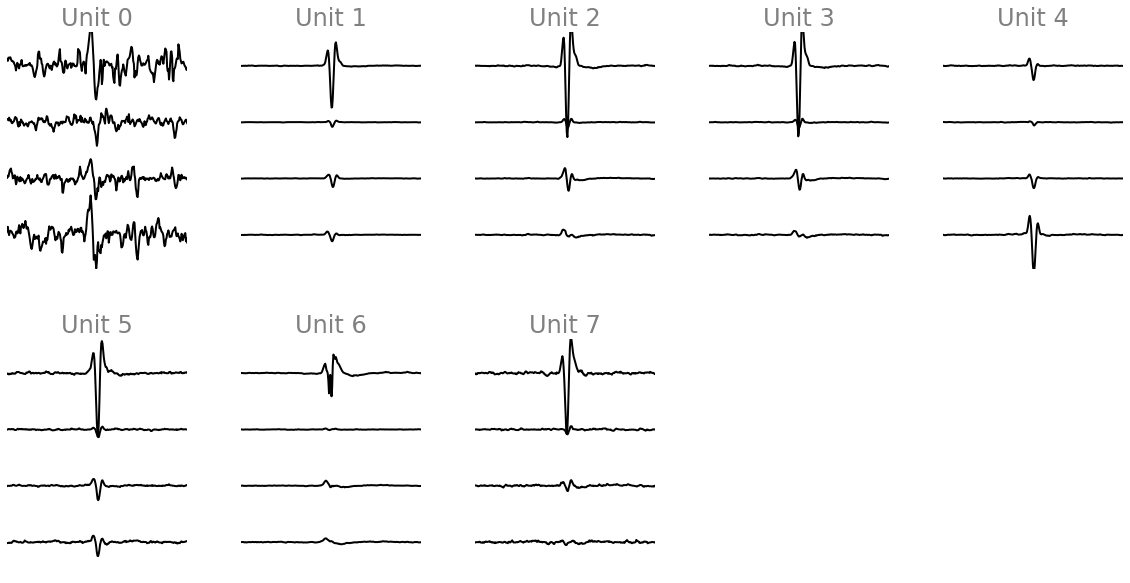

In [ ]:
# Inspect waveforms

w_wf = sw.plot_unit_templates(sorting=sorting_KL, recording=r_cache, unit_ids=[0,1,2,3,4,5,6,7])

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is

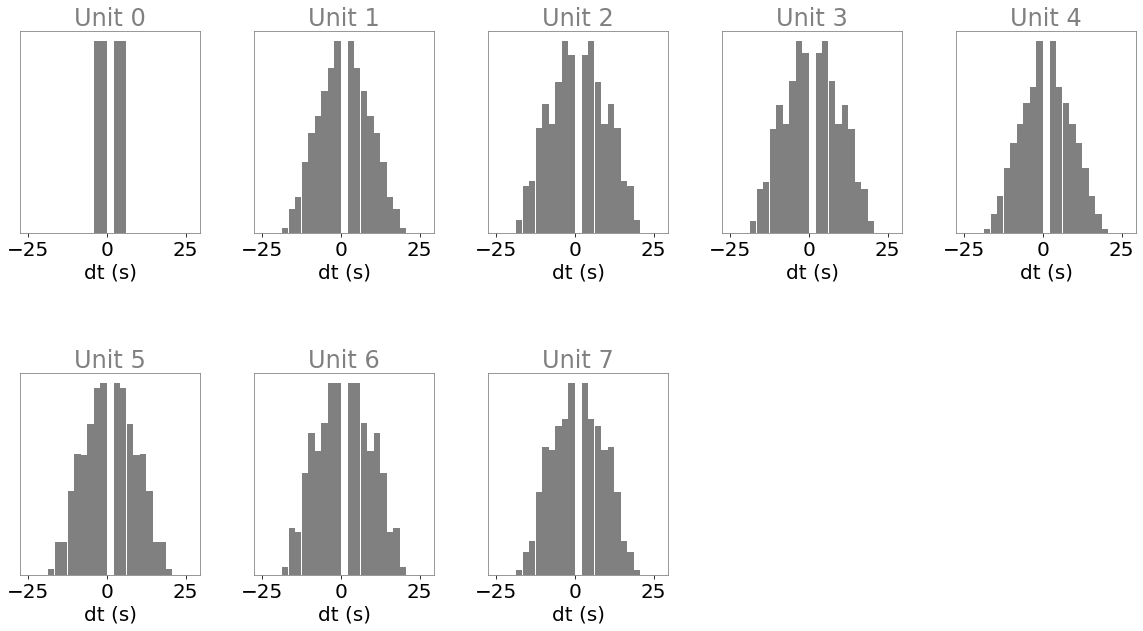

In [ ]:
w_acc = sw.plot_autocorrelograms(sorting_KL, unit_ids=[0,1,2,3,4,5,6,7])

### Compute extracellular features

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The postprocessing module of spiketoolkit allows one to compute several of these features:

In [ ]:
st.postprocessing.get_template_features_list()

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [ ]:
features = st.postprocessing.compute_unit_template_features(
    r_cache, 
    sorting_KL, 
    as_dataframe=True, 
    upsampling_factor=10
)
display(features)

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.002742,0.002621,-0.670719,1.427086e+08,-3.507819e+07
1,0.000129,0.000100,-0.560508,3.415068e+08,-1.114879e+07
2,0.000125,0.000096,-0.651688,6.037692e+08,-2.476658e+07
3,0.000131,0.000098,-0.638373,5.687902e+08,-2.317511e+07
4,0.000129,0.000102,-0.308790,2.717318e+08,-4.220511e+06
5,0.000131,0.000106,-0.513992,4.840509e+08,-1.750573e+07
6,0.000065,0.000125,-0.803630,4.543411e+08,-1.657060e+07
7,0.000140,0.000104,-0.592804,4.690690e+08,-2.058033e+07
8,0.001088,0.002194,-0.675851,3.083532e+08,-4.354359e+06
9,0.000052,0.000065,-0.705869,6.500063e+08,-1.068880e+07


We can either compute one metric at a time, or compute a subset of metrics using the compute_quality_metrics function:

In [ ]:
duration = recording.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_KL, duration_in_frames=duration)
print('ISI violations:', isi_violations)

snrs = st.validation.compute_snrs(sorting_KL, r_cache)
print('SNRs:', snrs)

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is

ISI violations: [   0.           18.00772984   17.56975695   17.47843135   18.79942567
   12.95014785   58.3321749    29.74372331    0.           47.24696774
   21.46099412   12.63196166   24.86428386    2.65670534   39.98653705
    0.            2.78327689    8.23786511    2.47954077    0.
    0.         1664.46858926   14.42664523   70.36446827    0.        ]
SNRs: [ 5.390336   5.5181527  9.442562   9.343866   4.833367   8.16025
  3.0658774  8.064291   8.732708   5.2863336  5.6609693  6.552438
  5.5207343 13.63063    3.9273896  3.0737364  5.4742775  3.3018587
  4.5205207  4.327707   4.8181114  5.8060265  5.852221   5.799432
  4.0707364]


In [ ]:
quality_metrics = st.validation.compute_quality_metrics(
    sorting_KL, 
    r_cache, 
    metric_names=['firing_rate', 'isi_violation', 'snr'], 
    as_dataframe=True
)
display(quality_metrics)

,firing_rate,isi_violation,snr
0,0.25,0.000000,5.390336
1,169.95,0.600251,5.518153
2,56.40,0.585652,9.442562
3,51.20,0.582608,9.343866
4,70.20,0.626641,4.833367
5,10.80,0.431667,8.160250
6,62.60,1.944386,3.065877
7,9.20,0.991447,8.064291
8,0.10,0.000000,8.732708
9,13.85,1.574883,5.286334


<a id="spike_curation"></a>
# 7. Curation
[back to index](#index)

### a) Manual curation using Phy¶

In [ ]:
st.postprocessing.export_to_phy(
    r_cache, 
    sorting_KL, 
    output_folder='phy_KL',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is

Converting to Phy format
Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:01<00:00,  1.19s/it]


Fitting PCA of 3 dimensions on 20601 waveforms
Projecting waveforms on PC


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

'location' property is not available and it will be linear.
Saving files
Saved phy format to:  /mnt/d/spikeinterface/hussaini-to-nwb/phy_KL
Run:

phy template-gui  /mnt/d/spikeinterface/hussaini-to-nwb/phy_KL/params.py


In [ ]:
%%capture --no-display
!phy template-gui phy_KL/params.py

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


After curating the results we can reload it using the PhySortingExtractor:

In [ ]:
sorting_KL_phy_curated = se.PhySortingExtractor('phy_KL/', exclude_cluster_groups=['noise'])

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/phyextractors/phyextractors.py:145: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(row[1], (int, np.int, float, np.float, str)) and len(row) == 2:
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/phyextractors/phyextractors.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar typ

In [ ]:
print(len(sorting_KL_phy_curated.get_unit_ids()))
print(f"Unit ids after manual curation: {sorting_KL_phy_curated.get_unit_ids()}")

25
Unit ids after manual curation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


### b) Automatic curation based on quality metrics

In [ ]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [ ]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)

In [ ]:
len(sorting_auto.get_unit_ids())

6

In [ ]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, r_cache, snr_thresh, 'less')

In [ ]:
len(sorting_auto.get_unit_ids())

3

### c) Consensus-based curation

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the comparison module. We first compare and match the output spike trains of the different sorters, and we can then extract a new SortingExtractor with only the units in agreement.

In [ ]:
mcmp = sc.compare_multiple_sorters([sorting_KL, sorting_IC], ['KL', 'IC'], spiketrain_mode='union',
                                   verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing:  KL  and  IC
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


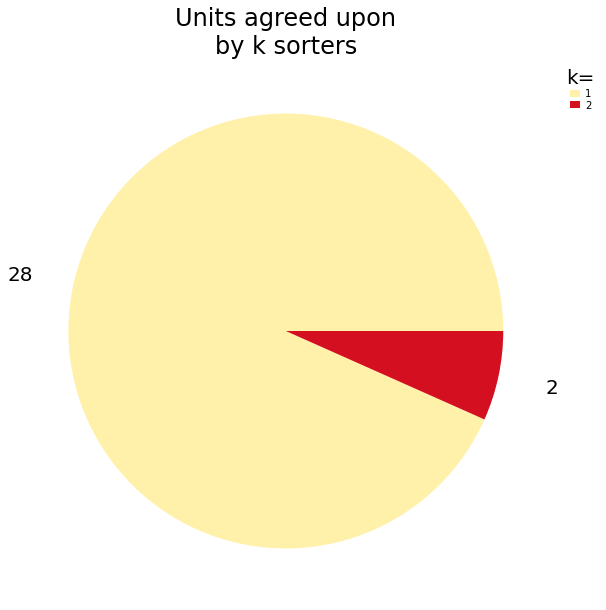

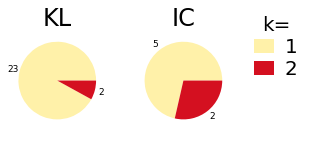

In [ ]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [ ]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [ ]:
agreement_sorting.get_unit_ids()

[13, 20]

In [ ]:
cmp_manual_agr = sc.compare_sorter_to_ground_truth(sorting_IC_phy_curated, agreement_sorting)

NameError: name 'sorting_IC_phy_curated' is not defined

In [ ]:
w_agr = sw.plot_agreement_matrix(cmp_manual_agr)

In [ ]:
st.postprocessing.export_to_phy(recording_cache, 
                                agreement_sorting, output_folder='phy_AGR',
                                grouping_property='group', verbose=True, recompute_info=True)

In [ ]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

<a id="export_nwb"></a>
# 7. Save to / load from NWB
[back to index](#index)

In [ ]:
# TODO ...

In [ ]:
metadata = {'Ecephys': {'Device': [{'name': 'open-ephys',
                                    'description': 'Open Ephys acquisition board'}]}}

In [ ]:
se.NwbRecordingExtractor.write_recording(recording_cache, 'si_tutorial.nwb', metadata=metadata)

In [ ]:
se.NwbSortingExtractor.write_sorting(sorting_IC, 'si_tutorial.nwb')

In [ ]:
recording_nwb = se.NwbRecordingExtractor('si_tutorial.nwb')
sorting_nwb = se.NwbSortingExtractor('si_tutorial.nwb')

<a id="export_tint"></a>
# 8. Save to / load from TINT
[back to index](#index)

In [ ]:
# TODO ...

In [ ]:
# eof